In [93]:
import re
import polars
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas
import math

In [125]:
closest_square = lambda x : math.ceil(math.sqrt(x))

In [126]:
closest_square(5)

3

In [103]:

file = "../experimentlog.txt"

# Regex with named groups for elapsed time and records
pattern = (
    r'^(?P<TimeStamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| '
    r'(?P<LogType>\w+) \| '
    r'(?P<FuncRaw>[\w_]+)\s*\| '
    r'(?P<Transport>\w+)\s*\| '
    r'(?P<Status>\w+)\s*\| '
    r'\s*(?P<Latency>[\d.]+)s \| '
    r'\s*records=(?P<records>\d+)'
)
regex = re.compile(pattern)

data = []

with open(file, "r") as f:
    for line in f:
        line = line.strip()
        match = regex.search(line)
        if match:
            row = match.groupdict()
            # Convert types
            row["Latency"] = float(row["Latency"])
            row["records"] = int(row["records"])
            data.append(row)

df = polars.DataFrame(data)
del data

grouped = (
    df.group_by(["records", "Transport"])
      .agg([
          polars.col("Latency").sum().alias("Latency_sum"),
          polars.col("Latency").mean().alias("Latency_mean"),
          polars.col("Latency").min().alias("Latency_min"),
          polars.col("Latency").max().alias("Latency_max"),
          polars.col("Latency").std().alias("Latency_std"),
          polars.count("Latency").alias("count")
      ])
)
grouped = grouped.sort('records', descending=True)
grouped.show(100)


records,Transport,Latency_sum,Latency_mean,Latency_min,Latency_max,Latency_std,count
i64,str,f64,f64,f64,f64,f64,u32
1000,"""arrow_grpc""",1.143381,0.004971,0.003974,0.014303,0.001089,230
1000,"""arrow""",1.926233,0.008375,0.006718,0.019108,0.001333,230
1000,"""cnpnp""",1.607612,0.00699,0.005783,0.016666,0.001305,230
1000,"""http""",1.470836,0.006395,0.005115,0.015979,0.0015,230
1000,"""cnpnp_grpc""",1.190154,0.005175,0.003931,0.01548,0.001188,230
1000,"""grpc""",1.074711,0.004673,0.003734,0.013137,0.001033,230
100,"""arrow""",0.930832,0.004047,0.003532,0.005243,0.000295,230
100,"""grpc""",0.583293,0.002536,0.002294,0.003262,0.000178,230
100,"""arrow_grpc""",0.598339,0.002601,0.002395,0.003261,0.000175,230


In [97]:
df_pandas = df.to_pandas()

summary_rows = []

# Loop over unique record groups
for r in df_pandas['records'].unique():
    df_r = df_pandas[df_pandas['records'] == r]
    
    # Compute mean and std per Transport
    stats = df_r.groupby('Transport')['Latency'].agg(['mean', 'std']).reset_index()
    
    # ANOVA
    model = ols('Latency ~ C(Transport)', data=df_r).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table['PR(>F)']['C(Transport)']
    
    # Add record group to stats
    stats['records'] = r
    stats['anova_p'] = p_value
    
    summary_rows.append(stats)

# Combine all record groups
summary_df = pandas.concat(summary_rows, ignore_index=True)

print(summary_df)

     Transport      mean       std  records        anova_p
0        arrow  0.004057  0.008837       10   2.241069e-09
1   arrow_grpc  0.002364  0.000191       10   2.241069e-09
2        cnpnp  0.003310  0.000240       10   2.241069e-09
3   cnpnp_grpc  0.002242  0.000146       10   2.241069e-09
4         grpc  0.002226  0.000172       10   2.241069e-09
5         http  0.003284  0.000383       10   2.241069e-09
6        arrow  0.004047  0.000295      100   0.000000e+00
7   arrow_grpc  0.002601  0.000175      100   0.000000e+00
8        cnpnp  0.003828  0.000380      100   0.000000e+00
9   cnpnp_grpc  0.002653  0.000195      100   0.000000e+00
10        grpc  0.002536  0.000178      100   0.000000e+00
11        http  0.003615  0.000252      100   0.000000e+00
12       arrow  0.008375  0.001333     1000  2.330105e-217
13  arrow_grpc  0.004971  0.001089     1000  2.330105e-217
14       cnpnp  0.006990  0.001305     1000  2.330105e-217
15  cnpnp_grpc  0.005175  0.001188     1000  2.330105e-2

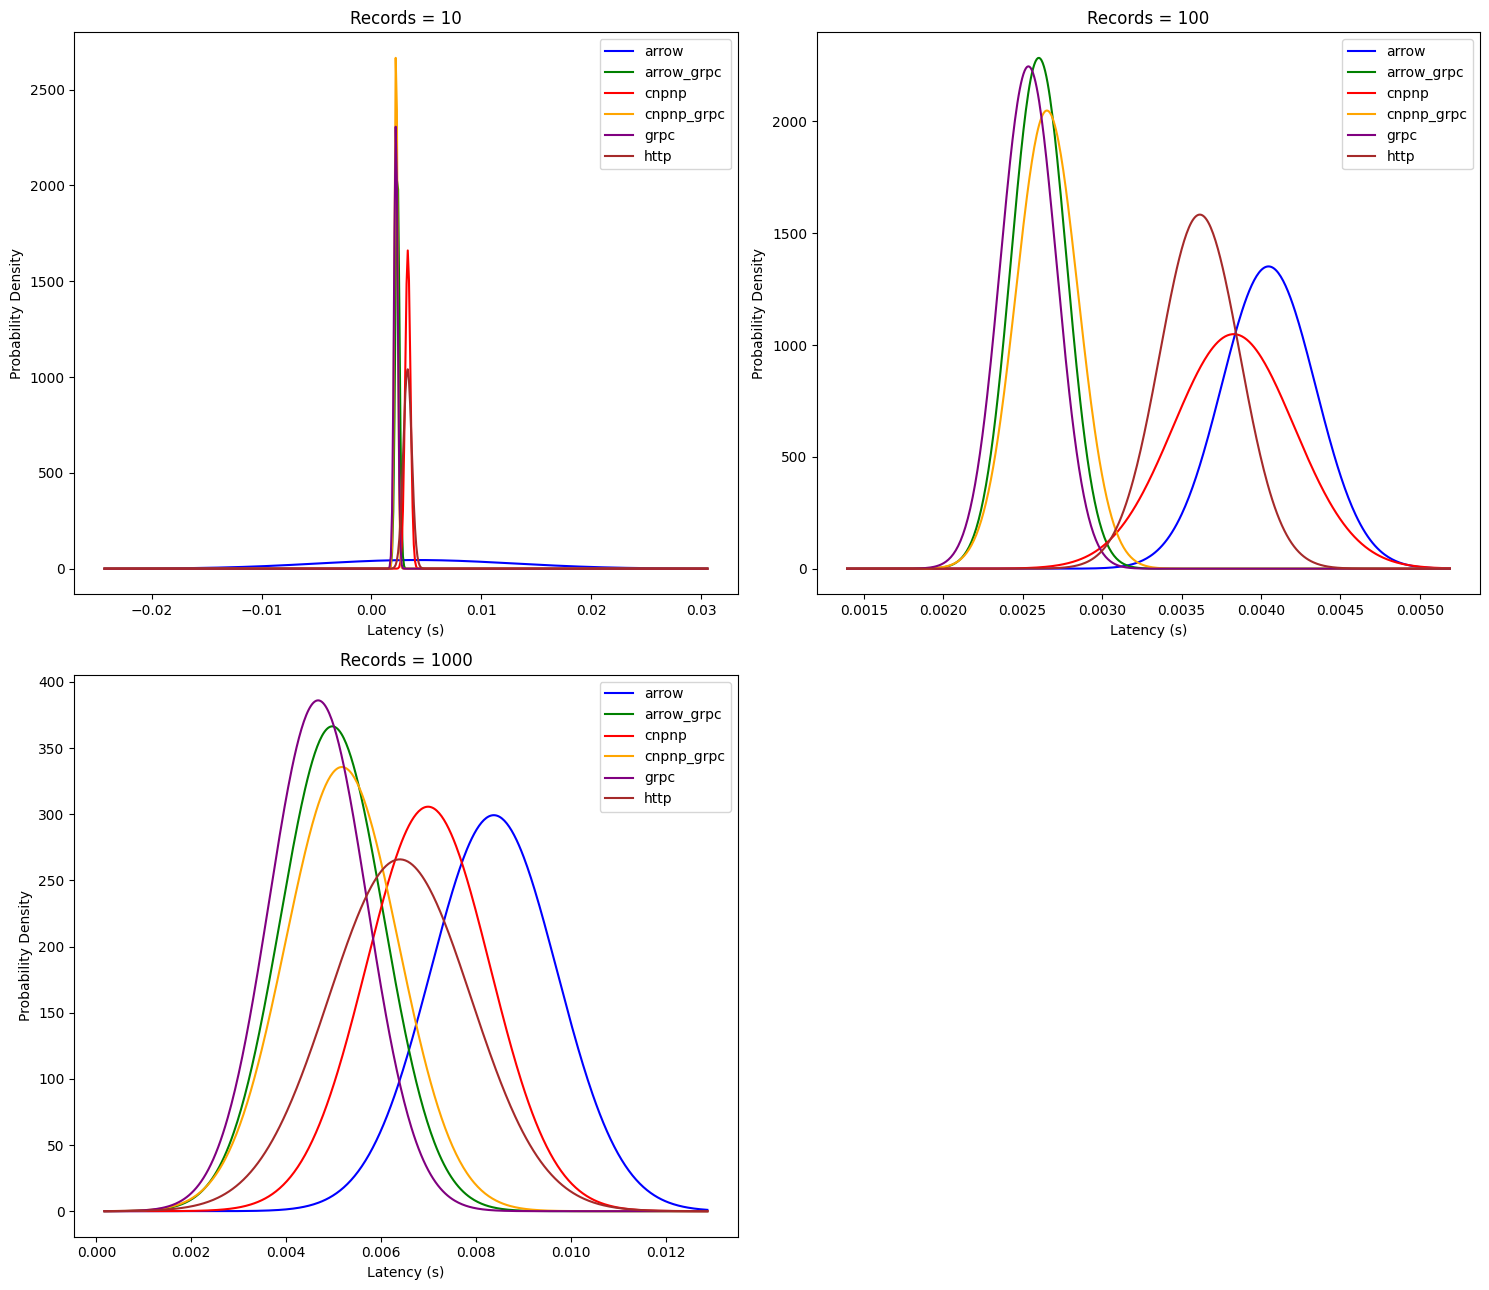

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd

# Assuming your summary_df from earlier
# Columns: Transport, mean, std, records, anova_p

records_groups = summary_df['records'].unique()
transports = summary_df['Transport'].unique()

plots_per_row = closest_square(len(records_groups))

fig, axes = plt.subplots(plots_per_row, plots_per_row, figsize=(15, 13))
axes = axes.flatten()

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

for i, r in enumerate(records_groups):
    ax = axes[i]
    df_r = summary_df[summary_df['records'] == r]
    
    x_min = df_r['mean'].min() - 3*df_r['std'].max()
    x_max = df_r['mean'].max() + 3*df_r['std'].max()
    x = np.linspace(x_min, x_max, 500)
    
    for j, transport in enumerate(transports):
        row = df_r[df_r['Transport'] == transport].iloc[0]
        y = norm.pdf(x, loc=row['mean'], scale=row['std'])
        ax.plot(x, y, label=transport, color=colors[j])
    
    ax.set_title(f"Records = {r}")
    ax.set_xlabel("Latency (s)")
    ax.set_ylabel("Probability Density")
    ax.legend()

# Hide unused axes if any
for k in range(i+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()
